## Model partition calibration example

In [1]:
% matplotlib inline

import numpy
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from matplotlib import pylab as pylab
from matplotlib import pyplot as plt

from data_models.data_model_helpers import export_skymodel_to_hdf5
from data_models.data_model_helpers import import_blockvisibility_from_hdf5
from data_models.data_model_helpers import import_skymodel_from_hdf5
from data_models.memory_data_models import SkyModel
from data_models.parameters import arl_path
from data_models.polarisation import PolarisationFrame
from processing_components.simulation.mpc import expand_skymodel_by_skycomponents
from processing_library.image.operations import copy_image, create_empty_image_like
from processing_library.util.coordinate_support import simulate_point
from workflows.arlexecute.calibration.calibration_arlexecute import calibrate_list_arlexecute_workflow
from workflows.arlexecute.imaging.imaging_arlexecute import deconvolve_list_arlexecute_workflow
from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow
from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow
from workflows.arlexecute.pipelines.pipeline_mpccal_arlexecute import mpccal_skymodel_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import convolve_skymodel_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow
from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client
from wrappers.arlexecute.skymodel.operations import calculate_skymodel_equivalent_image
from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.serial.calibration.calibration_control import calibrate_function
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.skycomponent.operations import find_skycomponents


In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
n_workers=8
c = get_dask_Client(memory_limit=256 * 1024 * 1024 * 1024 // n_workers, n_workers=n_workers)
arlexecute.set_client(client=c)
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:34319': None,
 'tcp://127.0.0.1:36027': None,
 'tcp://127.0.0.1:37447': None,
 'tcp://127.0.0.1:40997': None,
 'tcp://127.0.0.1:41005': None,
 'tcp://127.0.0.1:44255': None,
 'tcp://127.0.0.1:45327': None,
 'tcp://127.0.0.1:46151': None}

### Read the previously prepared observation

In [5]:
blockvis = import_blockvisibility_from_hdf5('results/low-sims-mpc-skymodel-noniso-blockvis_rmax10000.0.hdf5')
vobs = convert_blockvisibility_to_visibility(blockvis)

### Initialization phase

#### Read the previous iteration of skymodels, $\theta_p^{(n)}$. Each skymodel will contain a mask based on the decomposition, an image and gaintable derived from ICAL

In [6]:
nsources = 14
iteration = 0
rmax = 10000.0
ncycles = 10
theta_list = import_skymodel_from_hdf5("results/low-sims-mpc-skymodel_iteration%d_rmax%.1f.hdf5" %
                                       (iteration, rmax))
model = create_empty_image_like(theta_list[0].image)

future_vobs = arlexecute.scatter(vobs)
psf_obs = invert_list_arlexecute_workflow([future_vobs], [model], context='2d', dopsf=True)
theta_list = arlexecute.scatter(theta_list)

def progress(res, tl_list, gt_list, it):
    print('Iteration %d' % it)
    
    print('Length of theta = %d' % len(tl_list))
    
    print(qa_image(res, context='Residual image: iteration %d' % it))
    export_image_to_fits(res, "results/low-sims-mpc-residual_iteration%d_rmax%.1f.hdf5" %
                         (it, rmax))
    
    combined_model = calculate_skymodel_equivalent_image(tl_list)
    print(qa_image(combined_model, context='Combined model: iteration %d' % it))
    export_image_to_fits(combined_model, "results/low-sims-mpc-model_iteration%d_rmax%.1f.hdf5" %
                         (it, rmax))
    
    plt.clf()
    for i in range(len(tl_list)):
        plt.plot(numpy.angle(tl_list[i].gaintable.gain[:, :, 0, 0, 0]).flatten(),
                 numpy.angle(gt_list[i]['T'].gain[:, :, 0, 0, 0]).flatten(),
                 '.')
    plt.xlabel('Current phase')
    plt.ylabel('Update to phase')
    plt.xlim([-numpy.pi, numpy.pi])
    plt.ylim([-numpy.pi, numpy.pi])
    plt.title("MPCCal %dsources iteration%d: Change in phase" % (nsources, it))
    plt.savefig("figures/low-sims-mpc-skymodel-phase-change_iteration%d.jpg" % (it))
    plt.show()
    return tl_list

result = mpccal_skymodel_list_arlexecute_workflow(future_vobs, model, theta_list, nmajor=10, context='2d',
                                                  mpccal_progress=progress, algorithm='msclean',
                                                  scales=[0, 3, 10],
                                                  fractional_threshold=0.3, threshold=0.1,
                                                  gain=0.1, niter=1000,
                                                  deconvolve_facets=8,
                                                  deconvolve_overlap=32,
                                                  deconvolve_taper='tukey',
                                                  psf_support=512, calibration_context='T')

(theta_list, residual) = arlexecute.compute(result, sync=True)

print('mpccal finished')

export_skymodel_to_hdf5(theta_list, "results/low-sims-mpc-skymodel_iteration%d_rmax%.1f.hdf5" % (iteration, rmax))


/home/timcornwell/anaconda3/envs/arl/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 134.22 MB detected in task graph: 
  ([<data_models.memory_data_models.Image object at 0x7f8420d36a58>],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Execution using Dask took 1757.759 seconds
mpccal finished


In [7]:
combined_model = calculate_skymodel_equivalent_image(theta_list)
export_image_to_fits(combined_model, 'results/low-sims-mpc-deconvolved_rmax%.1f.fits' % (rmax))

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:54346 remote=tcp://127.0.0.1:38019>


In [8]:
from workflows.arlexecute.imaging.imaging_arlexecute import restore_list_arlexecute_workflow
result=restore_list_arlexecute_workflow([combined_model], psf_obs, [(residual, 0.0)])

In [9]:
result=arlexecute.compute(result, sync=True)

arlexecute.compute: Execution using Dask took 46.923 seconds


In [10]:
print(qa_image(result[0], context='MPCCal restored image'))

Quality assessment:
	Origin: qa_image
	Context: MPCCal restored image
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '4.949593978873193'
		min: '-0.16754046625790325'
		rms: '0.028338416316605577'
		sum: '2833.8980769188406'
		medianabs: '0.01712172890899497'
		median: '-9.58341461154281e-05'



In [11]:
recovered_mpccal_components = find_skycomponents(result[0], fwhm=2, threshold=0.15, npixels=12)
print(len(recovered_mpccal_components))
print(recovered_mpccal_components[0])
from data_models.data_model_helpers import export_skycomponent_to_hdf5
export_skycomponent_to_hdf5(recovered_mpccal_components, 
                            'results/low-sims-mpc-components_rmax%.1f.hdf5' % (rmax))


82
Skycomponent:
	Name: Segment 0
	Flux: [[0.25174391]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (2.62681375, -44.36960969)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



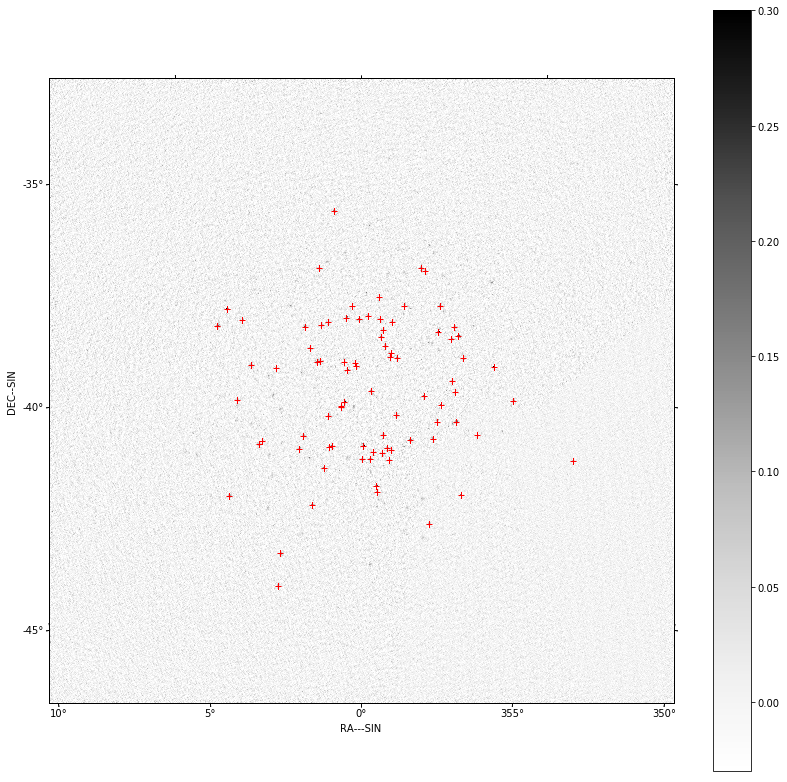

In [12]:
show_image(result[0], vmax=0.3, vmin=-0.03, components=recovered_mpccal_components)
export_image_to_fits(result[0], 'results/low-sims-mpc-restored_rmax%.1f.fits' % (rmax))
plt.show()

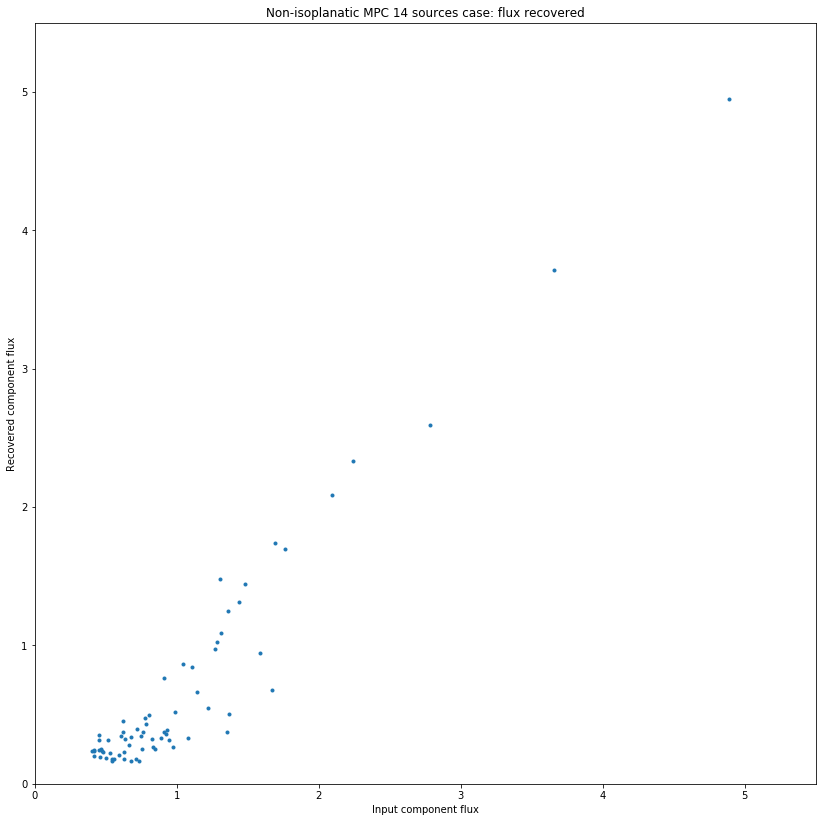

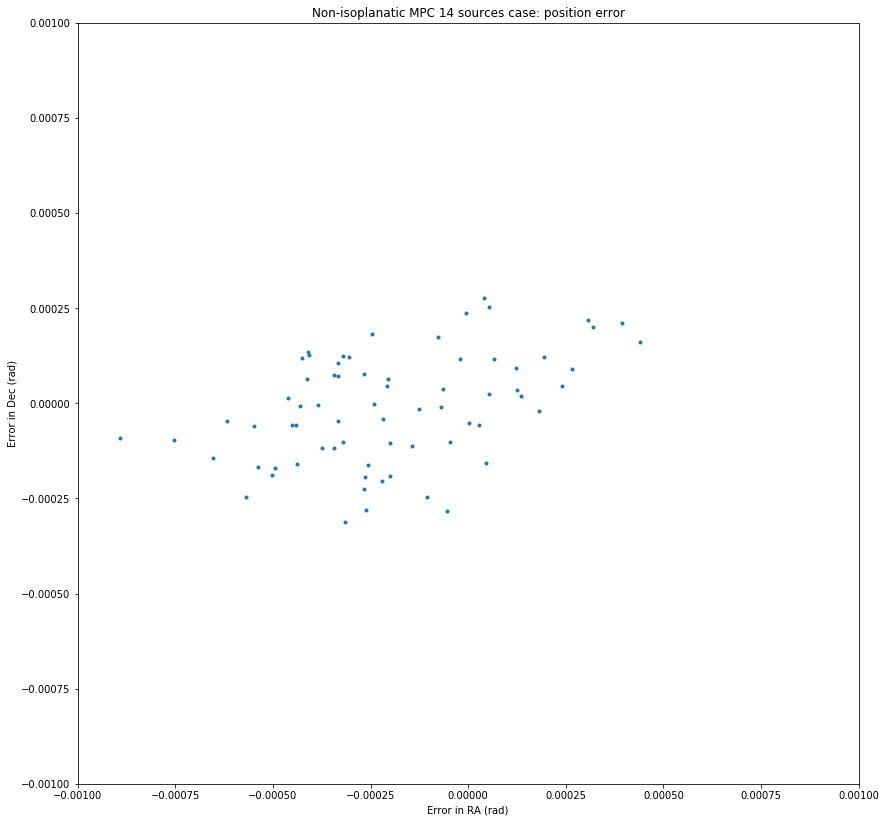

In [14]:
from data_models.data_model_helpers import import_skymodel_from_hdf5
gleam_skymodel_iso=import_skymodel_from_hdf5('results/low-sims-mpc-iso-skymodel_rmax%.1f.hdf5' % rmax)
from processing_components.skycomponent.operations import filter_skycomponents_by_flux
bright_gleam=filter_skycomponents_by_flux(gleam_skymodel_iso.components, flux_min=0.4)
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_bright_gleam=sorted(bright_gleam, key=max_flux, reverse=True)

from wrappers.serial.skycomponent.operations import find_skycomponent_matches
matches = find_skycomponent_matches(recovered_mpccal_components, sorted_bright_gleam, tol=1e-3)
x=list()
y=list()
dx=list()
dy=list()
for match in matches:
    y.append(recovered_mpccal_components[match[0]].flux[0,0])
    x.append(sorted_bright_gleam[match[1]].flux[0,0])
    dx.append(recovered_mpccal_components[match[0]].direction.ra.rad-sorted_bright_gleam[match[1]].direction.ra.rad)
    dy.append(recovered_mpccal_components[match[0]].direction.dec.rad-sorted_bright_gleam[match[1]].direction.dec.rad)
        
plt.clf()
plt.plot(x, y, '.')
plt.xlim([0.0, 5.5])
plt.ylim([0.0, 5.5])
plt.xlabel('Input component flux')
plt.ylabel('Recovered component flux')
plt.title('Non-isoplanatic MPC: flux recovered')
plt.savefig('low-sims-mpc_mpccal_noniso_flux_errors.jpg')
plt.show()
    
plt.clf()
plt.plot(dx, dy, '.')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.xlabel('Error in RA (rad)')
plt.ylabel('Error in Dec (rad)')
plt.title('Non-isoplanatic MPC: position error')
plt.savefig('low-sims-mpc_mpccal_noniso_position_errors.jpg')
plt.show()
    

In [15]:
oldscreen=import_image_from_fits('screens/low_screen_5000.0r0_0.100rate.fits')
from processing_components.simulation.ionospheric_screen import grid_gaintable_to_screen
from processing_components.image.operations import create_empty_image_like
newscreen = create_empty_image_like(oldscreen)
gaintables = [th.gaintable for th in theta_list]
newscreen, weights = grid_gaintable_to_screen(blockvis, gaintables, newscreen)
print(qa_image(newscreen))
export_image_to_fits(newscreen, 'results/low-sims-mpc_mpccal-screen_rmax%.1f.fits' % (rmax))
export_image_to_fits(weights, 'results/low-sims-mpc_mpccal-screenweights_rmax%.1f.fits' % (rmax))

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 61, 2000, 2000)'
		max: '3.1415325446550044'
		min: '-3.1410604139199685'
		rms: '0.016339248951083615'
		sum: '-1181.6489953580476'
		medianabs: '0.0'
		median: '0.0'



In [17]:
export_image_to_fits(result[0], 'results/low-sims-mpc-restored_rmax%.1f.fits' % (rmax))

In [16]:
arlexecute.close()

arlexcute.close: closing down Dask Client


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/timcornwell/anaconda3/envs/arl/lib/python3.6/site-packages/tornado/gen.py", line 936, in error_callback
    future.result()
concurrent.futures._base.CancelledError
